<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log
import numpy as np

from nlp.dataset import plot_frequencies, plot_roc, save_ngram_counts
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace
from torch.optim import Adam

In [2]:
DS_NAME = 'wikicorpus'
LIMIT_PROP = 0.001
prec = LIMIT_PROP * 100
DS_ITEM_COUNTS_PATH = f"nlp/data/{prec}%_wikicorpus_2-grams.npz"
CONCAT = True

In [3]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###
save_ngram_counts('wikicorpus', limit_prop=LIMIT_PROP,
                 n=2, tokens_key='sentence', concat=CONCAT, name='tagged_en')

TypeError: save_ngram_counts() missing 1 required positional argument: 'config'

# actual bigrams frequency

there are 54113 bigrams


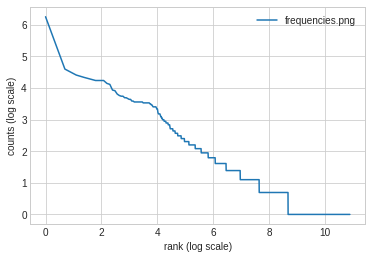

In [3]:
counts = np.load(DS_ITEM_COUNTS_PATH)['y']
print(f'there are {len(counts)} bigrams')
plot_frequencies(counts, 'rank (log scale)', 'counts (log scale)', 'frequencies.png')

In [4]:
indices = np.argsort(counts)
bigrams = np.load(DS_ITEM_COUNTS_PATH)['x']

print('Top 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[-5:]], counts[indices[-5:]])))

print('Bottom 5 frequent bigrams and their counts:')
print(list(zip(bigrams[indices[:5]], counts[indices[:5]])))

Top 5 frequent bigrams and their counts:
[('1 kings', 72), ('progressive rock', 76), ('traditional knowledge', 82), ('median income', 99), ('external links', 518)]
Bottom 5 frequent bigrams and their counts:
[('forbidden love', 1), ('der rotgelbe', 1), ('der krönende', 1), ('der austrucknende', 1), ('der hoffende', 1)]


# evaluating original count-min and count-sketch algorithms on data

In [5]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE ='cmin_wikicorpus' #save_results to path
SEED = 69
N_HASHES = [1,2,3,4] 
SPACE_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS = 22 #n_processes used 
DATA_NAME ='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH = True

In [9]:
cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/0.1%_wikicorpus_2-grams.npz
data #: 54113, shape (54113,)
positive ratio: 1.25465, max 518.000000, min 1.000000


count_sketch: # hashes 1, # buckets 75000 - loss 0.69	 time: 13.04 sec
count_sketch: # hashes 1, # buckets 150000 - loss 0.38	 time: 13.10 sec
count_sketch: # hashes 1, # buckets 250000 - loss 0.24	 time: 13.24 sec
count_sketch: # hashes 1, # buckets 100000 - loss 0.54	 time: 13.40 sec
count_sketch: # hashes 1, # buckets 300000 - loss 0.20	 time: 13.40 seccount_sketch: # hashes 1, # buckets 350000 - loss 0.17	 time: 13.40 sec
count_sketch: # hashes 1, # buckets 450000 - loss 0.14	 time: 13.39 sec

count_sketch: # hashes 1, # buckets 175000 - loss 0.33	 time: 13.50 sec
count_sketch: # hashes 2, # buckets 50000 - loss 0.76	 time: 13.59 sec
count_sketch: # hashes 1, # buckets 200000 - loss 0.29	 time: 13.67 seccount_sketch: # hashes 1, # buckets 750000 - loss 0.08	 time: 13.67 sec

count_sketch: # hashes 1, # buckets 25000 - loss 1.53	 time: 13.89 secco

In [6]:
### count min ###

COUNT_SKETCH = False

cme = CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

statistics for nlp/data/0.1%_wikicorpus_2-grams.npz
data #: 54113, shape (54113,)
positive ratio: 1.25465, max 518.000000, min 1.000000


count_min: # hashes 1, # buckets 50000 - loss 1.33	 time: 3.80 sec
count_min: # hashes 1, # buckets 75000 - loss 0.89	 time: 3.85 seccount_min: # hashes 1, # buckets 225000 - loss 0.29	 time: 3.83 sec

count_min: # hashes 1, # buckets 175000 - loss 0.37	 time: 4.04 sec
count_min: # hashes 1, # buckets 500000 - loss 0.13	 time: 4.12 seccount_min: # hashes 1, # buckets 400000 - loss 0.16	 time: 4.15 sec

count_min: # hashes 1, # buckets 25000 - loss 2.66	 time: 4.85 sec
count_min: # hashes 1, # buckets 300000 - loss 0.22	 time: 4.88 sec
count_min: # hashes 1, # buckets 250000 - loss 0.26	 time: 5.01 seccount_min: # hashes 1, # buckets 1000000 - loss 0.06	 time: 5.03 sec

count_min: # hashes 1, # buckets 750000 - loss 0.08	 time: 5.07 sec
count_min: # hashes 1, # buckets 450000 - loss 0.15	 time: 5.27 sec
count_min: # hashes 2, # buckets 25000 - loss 1.

# train estimation model

In [7]:

targets, preds = train_simple_model(config={
            'ds_name': 'wikicorpus',
            'embed_type': 'CharNGram',
            'embed_dim': 100,
            'op': 'concat',
            'n': 2,
            "limit_prop": 0.001,
            'num_workers': 10,
            "hidden_dim": 128,
            "dropout_prob": 0.0,
            "optim": Adam,
            "learning_rate": 0.0001,
            "batch_size": 128
            },
        args={
            # 'gpus': 4,
            'max_epochs': 60
            })

Global seed set to 123
GPU available: False, used: False
TPU available: None, using: 0 TPU cores




HYPERPARAMS
-----------
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 100,
            'embed_type': 'CharNGram',
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.001,
            'n': 2,
            'num_workers': 10,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}
{'args': {'max_epochs': 60}}


Loading features from: 
/home/iddo/PycharmProjects/learning-ds/nlp/data/0.1%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


54113it [00:00, 65163.92it/s]
0it [00:00, ?it/s]

Loading features from: 
/home/iddo/PycharmProjects/learning-ds/nlp/data/0.1%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


54113it [00:00, 56940.70it/s]

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | l1        | Linear  | 25.7 K
2 | l2        | Linear  | 129   
3 | dropout   | Dropout | 0     
--------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.103     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0:  57%|█████▋    | 170/297 [00:01<00:01, 120.27it/s, loss=0.128, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 1:  57%|█████▋    | 170/297 [00:01<00:00, 161.19it/s, loss=0.127, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 2:  57%|█████▋    | 170/297 [00:01<00:00, 147.31it/s, loss=0.112, v_num=7] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  57%|█████▋    | 170/297 [00:01<00:00, 145.27it/s, loss=0.11, v_num=7]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  57%|█████▋    | 170/297 [00:01<00:00, 138.05it/s, loss=0.109, v_num=7] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  57%|█████▋    | 170/297 [00:01<00:00, 150.86it/s, loss=0.108, v_num=7] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  57%|█████▋    | 170/297 [00:01<00:00, 138.58it/s, loss=0.107, v_num=7] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  57%|█████▋    | 170/297 [00:01<00:00, 156.90it/s, loss=0.107, v_num=7] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  57%|█████▋    | 170/297 [00:01<00:00, 161.78it/s, loss=0.106, v_num=7] 
Validating: 0it 

Epoch 19:  57%|█████▋    | 170/297 [00:01<00:00, 161.81it/s, loss=0.0978, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 20:  57%|█████▋    | 170/297 [00:01<00:00, 164.56it/s, loss=0.097, v_num=7] 
Validating: 0it [00:00, ?it/s]
Epoch 21:  57%|█████▋    | 170/297 [00:01<00:00, 168.58it/s, loss=0.0963, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 22:  57%|█████▋    | 170/297 [00:01<00:00, 162.17it/s, loss=0.0956, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 23:  57%|█████▋    | 170/297 [00:01<00:00, 162.28it/s, loss=0.0949, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 24:  57%|█████▋    | 170/297 [00:01<00:00, 154.09it/s, loss=0.0943, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 25:  57%|█████▋    | 170/297 [00:01<00:00, 159.98it/s, loss=0.0935, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 26:  57%|█████▋    | 170/297 [00:01<00:00, 155.49it/s, loss=0.0928, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 27:  57%|█████▋    | 170/297 [00:01<00:00, 150.33it/s, loss=0.0921, v_num=7]
Valid

Epoch 39:  57%|█████▋    | 170/297 [00:01<00:00, 152.32it/s, loss=0.0838, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 40:  57%|█████▋    | 170/297 [00:01<00:00, 153.61it/s, loss=0.0832, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 41:  57%|█████▋    | 170/297 [00:01<00:00, 158.81it/s, loss=0.0825, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 42:  57%|█████▋    | 170/297 [00:01<00:00, 148.44it/s, loss=0.0818, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 43:  57%|█████▋    | 170/297 [00:01<00:00, 149.83it/s, loss=0.0812, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 44:  57%|█████▋    | 170/297 [00:01<00:00, 155.63it/s, loss=0.0805, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 45:  57%|█████▋    | 170/297 [00:01<00:00, 151.96it/s, loss=0.08, v_num=7]  
Validating: 0it [00:00, ?it/s]
Epoch 46:  57%|█████▋    | 170/297 [00:01<00:00, 159.36it/s, loss=0.0793, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 47:  57%|█████▋    | 170/297 [00:01<00:00, 152.38it/s, loss=0.0787, v_num=7]
Valid

Epoch 59:  57%|█████▋    | 170/297 [00:01<00:00, 154.68it/s, loss=0.0719, v_num=7]
Validating: 0it [00:00, ?it/s]
Epoch 59: 100%|██████████| 297/297 [00:01<00:00, 190.81it/s, loss=0.0719, v_num=7]
Loading features from: 
/home/iddo/PycharmProjects/learning-ds/nlp/data/0.1%_wikicorpus_2-grams_concat_CharNGram.100_features.npz


54113it [00:00, 67984.43it/s]


Testing: 100%|██████████| 127/127 [00:00<00:00, 291.52it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.09677436947822571}
--------------------------------------------------------------------------------
dumping test train and validation to:
train test valid
dumping test train and validation predictions to:
/home/iddo/PycharmProjects/learning-ds/nlp/pred_0.1%_wikicorpus_2-grams_concat_CharNGram.100.npz


HYPERPARAMS
-----------
{'config': {'batch_size': 128,
            'dropout_prob': 0.0,
            'ds_name': 'wikicorpus',
            'embed_dim': 100,
            'embed_type': 'CharNGram',
            'hidden_dim': 128,
            'learning_rate': 0.0001,
            'limit_prop': 0.001,
            'n': 2,
            'num_workers': 10,
            'op': 'concat',
            'optim': <class 'torch.optim.adam.Adam'>}}
{'args': {'max_epochs': 60}}




No Skill: ROC AUC=0.50
Learned: ROC AUC=0.77


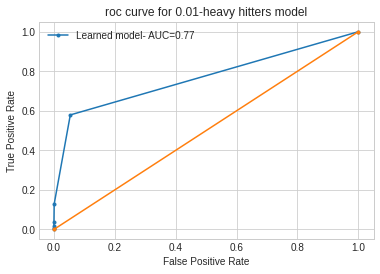

Saving plot...
Done.


<Figure size 432x288 with 0 Axes>

In [8]:
plot_roc(targets=targets, preds=preds, split='test', hh_frac=0.01)

In [18]:
TEST_RESULTS =[f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
VALID_RESULTS = [f"./nlp/pred_{prec}%_wikicorpus_2-grams_concat_CharNGram.100.npz"]
TEST_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_test.npz"]
VALID_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz"]
LOOKUP_DATA = [f"./nlp/true_{prec}%_wikicorpus_2-grams_concat_CharNGram.100_train.npz"]
SAVE ='cmin_wikicorpus'
SEED = 69
SPACE_LIST = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST = [1, 2, 3, 4]
PERFECT_ORDER = False
N_WORKERS = 7
DATA_NAME ='wikicorpus'
COUNT_SKETCH = False

In [17]:
print('Running: with lookup, count min...')
# with lookup

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json

statistics for valid data:
/
h
o
m
e
/
i
d
d
o
/
P
y
c
h
a
r
m
P
r
o
j
e
c
t
s
/
l
e
a
r
n
i
n
g
-
d
s
/
n
l
p
/
t
r
u
e
_
0
.
1
%
_
w
i
k
i
c
o
r
p
u
s
_
2
-
g
r
a
m
s
_
c
o
n
c
a
t
_
C
h
a
r
N
G
r
a
m
.
1
0
0
_
v
a
l
i
d
.
n
p
z
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
/
h
o
m
e
/
i
d
d
o
/
P
y
c
h
a
r
m
P
r
o
j
e
c
t
s
/
l
e
a
r
n
i
n
g
-
d
s
/
n
l
p
/
t
r
u
e
_
0
.
1
%
_
w
i
k
i
c
o
r
p
u
s
_
2
-
g
r
a
m
s
_
c
o
n
c
a
t
_
C
h
a
r
N
G
r
a
m
.
1
0
0
_
t
e
s
t
.
n
p
z
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000




IsADirectoryError: [Errno 21] Is a directory: '/'

In [13]:
print('Running: no lookup, only using learned model count min...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: no lookup, only using learned model...
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json

statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000


data loading time: 0.0 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 20000, # hashes 3, # buckets 23333 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 35000, # hashes 1, # buckets 65000 - loss 0.00	 time: 0.11 sec

cutoff_count_min_param: bcut: 18750, # hashes 1, # buckets 56250 - loss 0.

cutoff_count_min_param: bcut: 8750, # hashes 4, # buckets 10625 - loss 1.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 33750 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.18	loss_avg 0.06
cutoff_count_min_param: bcut: 10000, # hashes 3, # buckets 20000 - loss 0.06	 time: 0.25 sec	loss_cf 0.00	loss_rd 1.17	loss_avg 0.99

cutoff_count_min_param: bcut: 1250, # hashes 4, # buckets 6875 - loss 0.99	 time: 0.69 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 41250 - loss 0.00	 time: 0.11 sec

cutoff_count_min_param: bcut: 10000, # hashes 4, # buckets 30000 - loss 0.00	 time: 0.37 sec
	loss_cf 0.00	loss_rd 1.45	loss_avg 0.53
cutoff_count_min_param: bcut: 10000, # hashes 1, # buckets 15000 - loss 0.53	 time: 0.25 sec	loss_cf 0.00	loss_rd 0.03	loss_avg 0.01

cutoff_count_min_param: bcut: 6250, # hashes 2, # buckets 62500 -

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 7500, # hashes 4, # buckets 22500 - loss 0.02	 time: 0.48 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


cutoff_count_min_param: bcut: 17500, # hashes 1, # buckets 32500 - loss 0.00	 time: 0.12 seccutoff_count_min_param: bcut: 30000, # hashes 3, # buckets 43333 - loss 0.00	 time: 0.07 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 31250, # hashes 1, # buckets 93750 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 30000, # hashes 4, # buckets 40000 - loss 0.00	 time: 0.07 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 12500, # hashes 4, # buckets 37500 - loss 0.00	 time: 0.27 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 17500, # hashes 2, # buckets 25000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 31250, # hashes 2, # buckets 6250

cutoff_count_min_param: bcut: 26250, # hashes 3, # buckets 67083 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 52500, # hashes 4, # buckets 63750 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 50000, # hashes 3, # buckets 58333 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 7500, # hashes 3, # buckets 52500 - loss 0.00	 time: 0.47 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 26250, # hashes 4, # buckets 56875 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 15000, # hashes 4, # buckets 26250 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 50000, # hashes 4, # buckets 56250 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 60000, # hashes 1, # buckets 900

cutoff_count_min_param: bcut: 52500, # hashes 3, # buckets 75833 - loss 0.00	 time: 0.17 sec
	loss_cf 0.00	loss_rd 0.20	loss_avg 0.13
cutoff_count_min_param: bcut: 5000, # hashes 2, # buckets 25000 - loss 0.13	 time: 0.50 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 0.00	 time: 0.22 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.01
cutoff_count_min_param: bcut: 10000, # hashes 1, # buckets 190000 - loss 0.01	 time: 0.38 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 22500, # hashes 4, # buckets 48750 - loss 0.00	 time: 0.28 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00


cutoff_count_min_param: bcut: 52500, # hashes 4, # buckets 70000 - loss 0.00	 time: 0.24 seccutoff_count_min_param: bcut: 8750, # hashes 2, # buckets 87500 - loss 0.00	 time: 0.49 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 70000, # hashes 1, # buckets 1300

cutoff_count_min_param: bcut: 100000, # hashes 4, # buckets 112500 - loss 0.00	 time: 0.14 seccutoff_count_min_param: bcut: 6250, # hashes 2, # buckets 12500 - loss 0.58	 time: 0.38 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 75000, # hashes 1, # buckets 225000 - loss 0.00	 time: 0.15 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


cutoff_count_min_param: bcut: 78750, # hashes 3, # buckets 101250 - loss 0.00	 time: 0.11 seccutoff_count_min_param: bcut: 37500, # hashes 4, # buckets 81250 - loss 0.00	 time: 0.13 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 11250, # hashes 4, # buckets 61875 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 30000, # hashes 1, # buckets 170000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 112500, # hashes 1, # buckets 137500 - loss 0.00	 time: 0.12 sec
	los

cutoff_count_min_param: bcut: 35000, # hashes 2, # buckets 175000 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 30000, # hashes 1, # buckets 270000 - loss 0.00	 time: 0.12 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 1.05	loss_avg 0.53
cutoff_count_min_param: bcut: 101250, # hashes 4, # buckets 106875 - loss 0.00	 time: 0.11 sec


cutoff_count_min_param: bcut: 7500, # hashes 1, # buckets 17500 - loss 0.53	 time: 0.33 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 105000, # hashes 3, # buckets 135000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 75000, # hashes 2, # buckets 125000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 45000, # hashes 3, # buckets 90000 - loss 0.00	 time: 0.12 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min

cutoff_count_min_param: bcut: 25000, # hashes 2, # buckets 125000 - loss 0.00	 time: 0.10 seccutoff_count_min_param: bcut: 70000, # hashes 3, # buckets 140000 - loss 0.00	 time: 0.14 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 135000, # hashes 4, # buckets 142500 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 112500, # hashes 1, # buckets 337500 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 130000 - loss 0.00	 time: 0.11 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 140000, # hashes 1, # buckets 210000 - loss 0.00	 time: 0.09 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 180000, # hashes 1, # buckets 220000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 25000, # hashes 3, # buckets 175000 - loss 0.00	 time: 0.11 se

cutoff_count_min_param: bcut: 45000, # hashes 1, # buckets 405000 - loss 0.00	 time: 0.09 seccutoff_count_min_param: bcut: 75000, # hashes 3, # buckets 191666 - loss 0.00	 time: 0.10 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


cutoff_count_min_param: bcut: 100000, # hashes 4, # buckets 150000 - loss 0.00	 time: 0.16 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 200000, # hashes 4, # buckets 225000 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 112500, # hashes 4, # buckets 243750 - loss 0.00	 time: 0.13 sec

cutoff_count_min_param: bcut: 157500, # hashes 1, # buckets 292500 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 20000, # hashes 2, # buckets 200000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 120000, # hashes 1, # 

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 125000, # hashes 4, # buckets 187500 - loss 0.00	 time: 0.10 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 202500, # hashes 1, # buckets 247500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 337500, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.14 seccutoff_count_min_param: bcut: 75000, # hashes 1, # buckets 675000 - loss 0.00	 time: 0.12 sec
cutoff_count_min_param: bcut: 160000, # hashes 1, # buckets 240000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 225000, # hashes 1, # buckets 525000 - loss 0.00	 time: 0.13 sec

cutoff_count_min_param: bcut: 90000, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_co

cutoff_count_min_param: bcut: 150000, # hashes 4, # buckets 325000 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 400000, # hashes 3, # buckets 466666 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 200000, # hashes 1, # buckets 800000 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 400000, # hashes 4, # buckets 450000 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 200000, # hashes 2, # buckets 500000 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 450000, # hashes 1, # buckets 550000 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 200000, # hashes 3, # buckets 400000 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 450000, # hashes 2

In [14]:
print('Running: perfect oracle... only using learned model count min...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: perfect oracle...
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json

statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000


data loading time: 0.0 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 20000, # hashes 3, # buckets 23333 - loss 0.00	 time: 0.11 sec

cutoff_count_min_param_perfect: bcut: 18750, # hashes 1, # buckets 56250 - loss 0.00	 time: 0.11 seccutoff_count_min_param_perfect: bcut: 35000, # hashes 1, # buckets 65000 - loss 

cutoff_count_min_param_perfect: bcut: 10000, # hashes 3, # buckets 36666 - loss 0.00	 time: 0.33 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 30000, # hashes 3, # buckets 35000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.05
cutoff_count_min_param_perfect: bcut: 3750, # hashes 3, # buckets 26250 - loss 0.05	 time: 0.43 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 30000, # hashes 4, # buckets 33750 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.03	loss_avg 0.01
cutoff_count_min_param_perfect: bcut: 6250, # hashes 2, # buckets 62500 - loss 0.01	 time: 0.35 sec
	loss_cf 0.00	loss_rd 2.06	loss_avg 0.73
cutoff_count_min_param_perfect: bcut: 8750, # hashes 4, # buckets 10625 - loss 0.73	 time: 0.40 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.03
cutoff_count_min_param_perfect: bcut: 10000, # hashes 3, # buckets 20000 - loss 0.03	 time: 0.37 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 12500, # hashes 4, # buckets 37500 - loss 0.00	 time: 0.28 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 25000, # hashes 3, # buckets 50000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 1.18	loss_avg 0.77
cutoff_count_min_param_perfect: bcut: 2500, # hashes 4, # buckets 7500 - loss 0.77	 time: 0.62 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.02	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 30000, # hashes 2, # buckets 50000 - loss 0.00	 time: 0.09 seccutoff_count_min_param_perfect: bcut: 7500, # hashes 4, # buckets 22500 - loss 0.02	 time: 0.52 sec
	loss_cf 0.00	loss_rd 3.97	loss_avg 0.94
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 15000, # hashes 4, # buckets 20000 - loss 0.00	 time: 0.17 seccutoff_count_min_param_perfect: bcut: 11250, # hashes 3, # buckets 12083 - loss 0.94	 time: 0.32 sec

	loss_cf 

cutoff_count_min_param_perfect: bcut: 15000, # hashes 1, # buckets 60000 - loss 0.00	 time: 0.17 sec
cutoff_count_min_param_perfect: bcut: 52500, # hashes 4, # buckets 63750 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 26250, # hashes 1, # buckets 148750 - loss 0.00	 time: 0.15 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 43750, # hashes 3, # buckets 56250 - loss 0.00	 time: 0.17 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 60000, # hashes 1, # buckets 90000 - loss 0.00	 time: 0.12 sec

cutoff_count_min_param_perfect: bcut: 15000, # hashes 2, # buckets 37500 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 26250, # hashes 2, # buckets 87500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 43750, # hashes 4, # buckets 65625 - loss 0.00	 time: 0.28 sec	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 8750, # hashes 2, # buckets 87500 - loss 0.00	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 78750, # hashes 3, # buckets 84583 - loss 0.00	 time: 0.23 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 50000, # hashes 3, # buckets 83333 - loss 0.00	 time: 0.21 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 22500, # hashes 2, # buckets 75000 - loss 0.00	 time: 0.23 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 52500, # hashes 1, # buckets 122500 - loss 0.00	 time: 0.20 sec
	loss_cf 0.00	loss_rd 1.06	loss_avg 0.57	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 5000, # hashes 3, # buckets 1

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param_perfect: bcut: 6250, # hashes 2, # buckets 12500 - loss 0.43	 time: 0.43 sec

cutoff_count_min_param_perfect: bcut: 10000, # hashes 4, # buckets 55000 - loss 0.00	 time: 0.42 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 78750, # hashes 2, # buckets 112500 - loss 0.00	 time: 0.12 sec

cutoff_count_min_param_perfect: bcut: 100000, # hashes 3, # buckets 116666 - loss 0.00	 time: 0.15 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 80000, # hashes 3, # buckets 93333 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 37500, # hashes 3, # buckets 95833 - loss 0.00	 time: 0.16 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 20000, # hashes 1, # buckets 180000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cut

cutoff_count_min_param_perfect: bcut: 75000, # hashes 4, # buckets 112500 - loss 0.00	 time: 0.16 seccutoff_count_min_param_perfect: bcut: 17500, # hashes 2, # buckets 175000 - loss 0.00	 time: 0.12 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


cutoff_count_min_param_perfect: bcut: 62500, # hashes 3, # buckets 104166 - loss 0.00	 time: 0.16 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 33750, # hashes 3, # buckets 86250 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 101250, # hashes 4, # buckets 106875 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 62500, # hashes 4, # buckets 93750 - loss 0.00	 time: 0.09 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.87	loss_avg 0.36cutoff_count_min_param_perfect: bcut: 17500, # hashes 3, # buckets 122500 - loss 0.00	 time: 0.12 sec
cutoff_count_min_param_perfect: bcut: 7500

cutoff_count_min_param_perfect: bcut: 120000, # hashes 1, # buckets 180000 - loss 0.00	 time: 0.10 sec

cutoff_count_min_param_perfect: bcut: 52500, # hashes 3, # buckets 134166 - loss 0.00	 time: 0.15 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 25000, # hashes 1, # buckets 225000 - loss 0.00	 time: 0.10 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 87500, # hashes 4, # buckets 106250 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 122500, # hashes 4, # buckets 148750 - loss 0.00	 time: 0.13 sec

cutoff_count_min_param_perfect: bcut: 45000, # hashes 4, # buckets 97500 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 120000, # hashes 2, # buckets 150000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut:

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param_perfect: bcut: 80000, # hashes 4, # buckets 140000 - loss 0.00	 time: 0.14 sec

cutoff_count_min_param_perfect: bcut: 135000, # hashes 3, # buckets 195000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 22500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 50000, # hashes 4, # buckets 150000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 175000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 157500, # hashes 4, # buckets 166250 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 87500, # hashes 4, # buckets 131250 - loss 0.00	 time: 0.13 

cutoff_count_min_param_perfect: bcut: 100000, # hashes 4, # buckets 175000 - loss 0.00	 time: 0.10 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 120000, # hashes 4, # buckets 160000 - loss 0.00	 time: 0.13 seccutoff_count_min_param_perfect: bcut: 67500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.13 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 150000, # hashes 4, # buckets 262500 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 225000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param_perfect: bcut: 180000, # hashes 4, # buckets 202500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 125000, # hashes 1

cutoff_count_min_param_perfect: bcut: 75000, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 300000, # hashes 1, # buckets 700000 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 262500, # hashes 1, # buckets 487500 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 50000, # hashes 4, # buckets 275000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 75000, # hashes 3, # buckets 275000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 300000, # hashes 2, # buckets 500000 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 262500, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 37500, # hashes 1, # buckets 712500 - loss 0.00	 time: 0.13 sec
cutoff_count_min_param_perfect: bcut: 12500, # hashes 4, # buckets 68750 - loss 0.00	 time: 0.34 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 50000, # hashes 1, # buckets 950000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param_perfect: bcut: 11250, # hashes 4, # buckets 61875 - loss 0.00	 time: 0.37 sec
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json
statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000

statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, s

# plot count min

plot testing results for lookup table
plot testing results for perfect CCM


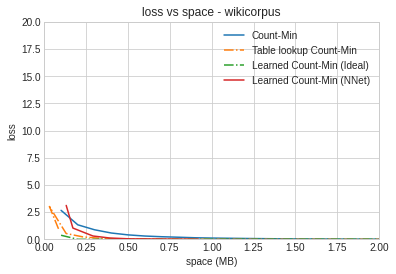

In [15]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_min_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.103]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()

In [19]:

print('Running: with lookup, count sketch...')
COUNT_SKETCH = True
PERFECT_ORDER = False
# with lookup

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

Running: with lookup, count sketch...
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json

statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000


statistics for lookup data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_train.npz
data #: 21647, shape (21647,)
positive ratio: 1.23772, max 99.000000, min 1.000000


data loading time: 0.0 sec
	loss_cf 0.00	loss_rd 0.81	loss_avg 0.81
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 1, # hashes 1, # cm buckets 20288 - loss 0.81	 time: 0.73 sec
	loss_cf 0.00	loss_rd 1.79	loss_avg 1.79
	# uniq 0 # cm 

	loss_cf 0.00	loss_rd 0.33	loss_avg 0.33
	# uniq 0 # cm 16233
	loss_cf 0.00	loss_rd 0.94	loss_avg 0.94lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 56706 - loss 0.33	 time: 1.63 sec
	# uniq
 0 # cm 16233
lookup_table_count_sketch: s_cut: 1, # hashes 4, # cm buckets 5072 - loss 0.94	 time: 1.92 sec
	loss_cf 0.00	loss_rd 0.65	loss_avg 0.65
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 10568 - loss 0.65	 time: 1.58 sec
	loss_cf 0.00	loss_rd 1.81	loss_avg 1.81
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 1676 - loss 1.81	 time: 1.87 sec
	loss_cf 0.00	loss_rd 0.99	loss_avg 0.99
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 1, # hashes 2, # cm buckets 10144 - loss 0.99	 time: 1.72 sec
	loss_cf 0.00	loss_rd 1.01	loss_avg 1.01
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 15853 - loss 1.01	 time: 1.59 sec
	loss_cf 0.00	loss_rd 0.48	loss_avg 0.48
	# uniq 0 # c

lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 2235 - loss 1.89	 time: 1.88 sec
	loss_cf 0.00	loss_rd 0.88	loss_avg 0.88
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 15853 - loss 0.88	 time: 1.51 sec
	loss_cf 0.00	loss_rd 0.92	loss_avg 0.92
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 1, # hashes 4, # cm buckets 5072 - loss 0.92	 time: 2.06 sec
	loss_cf 0.00	loss_rd 1.63	loss_avg 1.63
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 6706 - loss 1.63	 time: 1.27 sec
	loss_cf 0.00	loss_rd 0.31	loss_avg 0.31
	# uniq 0	loss_cf 0.00	loss_rd 0.22	loss_avg 0.22 # cm 
	# uniq16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 56706 - loss 0.31	 time: 1.73 sec 
0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 27235 - loss 0.22	 time: 1.82 sec
	loss_cf 0.00	loss_rd 0.52	loss_avg 0.52
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm b

	# uniq 0 # cm 16233lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 14176 - loss 0.43	 time: 1.64 sec

	loss_cf 0.00	loss_rd 1.78	loss_avg 1.78
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 1676 - loss 1.78	 time: 2.21 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.24
	# uniq	loss_cf 0.00	loss_rd 0.68	loss_avg 0.68 
	# uniq0  # cm 016233 # cm
 	loss_cf 0.00	loss_rd 0.31	loss_avg 0.31lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 81706 - loss 0.24	 time: 1.76 sec16233


lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 7926 - loss 0.68	 time: 2.25 sec
	# uniq
 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 20426 - loss 0.31	 time: 2.29 sec
	loss_cf 0.00	loss_rd 0.53	loss_avg 0.53
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 28353 - loss 0.53	 time: 2.13 sec
	loss_cf 0.00	loss_rd 0.41	loss_avg 0.41
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut

	loss_cf 0.00	loss_rd 0.15	loss_avg 0.15
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 181706 - loss 0.15	 time: 1.51 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.12
	# uniq	loss_cf 0.00	loss_rd 0.22	loss_avg 0.22 0
	# uniq 0 # cm  # cm 16233
16233lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 43902 - loss 0.12	 time: 2.20 sec

lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 27235 - loss 0.22	 time: 2.10 sec
	loss_cf 0.00	loss_rd 0.13	loss_avg 0.13
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 131706 - loss 0.13	 time: 2.00 sec
	loss_cf 0.00	loss_rd 0.18	loss_avg 0.18
	# uniq 0	loss_cf 0.00	loss_rd 0.14	loss_avg 0.14 
# cm	# uniq 16233 
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 106706 - loss 0.18	 time: 1.82 sec0
 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 39176 - loss 0.14	 time: 2.22 sec
	loss_cf 0.00	loss_rd 0.32	loss_avg 0.32
	# uniq 

lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 40853 - loss 0.41	 time: 2.10 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.12
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 43902 - loss 0.12	 time: 2.02 sec
	loss_cf 0.00	loss_rd 0.17	loss_avg 0.17
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 106706 - loss 0.17	 time: 1.97 sec
	loss_cf 0.00	loss_rd 0.14	loss_avg 0.14
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 39176 - loss 0.14	 time: 2.29 sec
	loss_cf 0.00	loss_rd 0.22	loss_avg 0.22
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 26676 - loss 0.22	 time: 1.67 sec
	loss_cf 0.00	loss_rd 0.09	loss_avg 0.09
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 52235 - loss 0.09	 time: 1.98 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.11
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # 

0lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 78353 - loss 0.24	 time: 2.14 sec
 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 68902 - loss 0.06	 time: 2.20 sec
	loss_cf 0.00	loss_rd 0.17	loss_avg 0.17
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 32926 - loss 0.17	 time: 1.80 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.12
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 52235 - loss 0.12	 time: 2.11 sec
	loss_cf 0.00	loss_rd 0.19	loss_avg 0.19
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 90853 - loss 0.19	 time: 1.99 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.11
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 45426 - loss 0.11	 time: 2.18 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 206706 - loss 0.10	 time: 1.81 sec
	los

lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 181706 - loss 0.10	 time: 1.37 sec
	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 102235 - loss 0.03	 time: 2.18 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 178353 - loss 0.10	 time: 2.17 sec
	loss_cf 0.00	loss_rd 0.09	loss_avg 0.09
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 51676 - loss 0.09	 time: 2.25 sec	loss_cf 0.00	loss_rd 0.14	loss_avg 0.14	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07

	# uniq 
0	# uniq  0# cm  16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 306706 - loss 0.07	 time: 1.95 sec# cm
 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 128353 - loss 0.14	 time: 2.16 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3

	loss_cf 0.00	loss_rd 0.11	loss_avg 0.11
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 45426 - loss 0.11	 time: 2.30 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
 # cm 16233	# uniq
 lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 76676 - loss 0.05	 time: 1.91 sec0
 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 256706 - loss 0.07	 time: 1.68 sec
	loss_cf 0.00	loss_rd 0.06	loss_avg 0.06
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 64176 - loss 0.06	 time: 2.07 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 178353 - loss 0.10	 time: 2.15 sec
	loss_cf 0.00	loss_rd 0.06	loss_avg 0.06
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 68902 - loss 0.06	 time: 2.17 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0

lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 118902 - loss 0.02	 time: 2.22 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03 # cm 
	# uniq16233
 lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 356706 - loss 0.10	 time: 2.00 sec
0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 89176 - loss 0.03	 time: 1.80 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 152235 - loss 0.01	 time: 2.11 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.04
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 456706 - loss 0.04	 time: 2.01 sec
	loss_cf 0.00	loss_rd 0.10	loss_avg 0.10
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 203353 - loss 0.10	 time: 1.73 sec
	loss_cf 0.00	loss_rd 0.11	loss_avg 0.11
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2

lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 135568 - loss 0.02	 time: 2.22 sec
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.02	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03
	# uniq
 	# uniq0 	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01 # cm0  
16233# cm
	# uniq 16233 
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 114176 - loss 0.03	 time: 2.24 sec0 # cm
 lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 706706 - loss 0.02	 time: 1.85 sec
16233
lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 239176 - loss 0.01	 time: 2.29 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.08
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 228353 - loss 0.08	 time: 2.16 sec
	loss_cf 0.00	loss_rd 0.09	loss_avg 0.09
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 203353 - loss 0.09	 time: 1.79 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 

lookup_table_count_sketch: s_cut: 0, # hashes 4, # cm buckets 176676 - loss 0.01	 time: 2.11 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 235568 - loss 0.01	 time: 2.27 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.04
	# uniq 0 # cm	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03
 16233	# uniq
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 135568 - loss 0.04	 time: 2.24 sec 
0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 456706 - loss 0.03	 time: 1.84 sec
	loss_cf 0.00	loss_rd 0.04	loss_avg 0.04
	# uniq 0  # cm16233
lookup_table_count_sketch: s_cut: 0, # hashes 2, # cm buckets 478353 - loss 0.04	 time: 1.74 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 406706 - loss 0.05	 time: 1.70 sec
	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03
	# uniq 0 # cm	loss_cf 0.00	loss_rd 0.08	loss_avg 0.08 
16233	# uni

lookup_table_count_sketch: s_cut: 1, # hashes 1, # cm buckets 20288 - loss 0.73	 time: 1.00 sec
	loss_cf 0.00	loss_rd 1.68	loss_avg 1.68
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 6706 - loss 1.68	 time: 0.95 sec
	loss_cf 0.00	loss_rd 0.52	loss_avg 0.52
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 31706 - loss 0.52	 time: 1.08 sec
	loss_cf 0.00	loss_rd 0.33	loss_avg 0.33
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 56706 - loss 0.33	 time: 1.21 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.25
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 1, # cm buckets 81706 - loss 0.25	 time: 1.14 sec
	loss_cf 0.00	loss_rd 0.15	loss_avg 0.15
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm buckets 35568 - loss 0.15	 time: 1.36 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.12
	# uniq 0 # cm 16233
lookup_table_count_sketch: s_cut: 0, # hashes 3, # cm

In [20]:
print('Running: no lookup, only using learned model count sketch...')

LOOKUP_DATA2 = None
PERFECT_ORDER = False

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: no lookup, only using learned model count sketch...
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json

statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000


data loading time: 0.0 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 18750, # hashes 1, # buckets 56250 - loss 0.00	 time: 0.06 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 20000, # hashes 3, # buckets 23333 - loss 0.00	 time: 0.12 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param: bcut: 35000, # hashes 1, # b

cutoff_count_sketch_param: bcut: 5000, # hashes 1, # buckets 95000 - loss 0.08	 time: 0.92 sec	loss_cf 0.00	loss_rd 0.41	loss_avg 0.21

cutoff_count_sketch_param: bcut: 7500, # hashes 4, # buckets 16250 - loss 0.21	 time: 0.95 sec
	loss_cf 0.00	loss_rd 0.92	loss_avg 0.40
cutoff_count_sketch_param: bcut: 8750, # hashes 3, # buckets 11250 - loss 0.40	 time: 0.68 sec
	loss_cf 0.00	loss_rd 0.76	loss_avg 0.64
cutoff_count_sketch_param: bcut: 1250, # hashes 3, # buckets 8750 - loss 0.64	 time: 1.49 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.02
cutoff_count_sketch_param: bcut: 10000, # hashes 3, # buckets 36666 - loss 0.02	 time: 0.72 sec
	loss_cf 0.00	loss_rd 0.20	loss_avg 0.07
cutoff_count_sketch_param: bcut: 10000, # hashes 1, # buckets 40000 - loss 0.07	 time: 0.62 sec
	loss_cf 0.00	loss_rd 0.20	loss_avg 0.14
cutoff_count_sketch_param: bcut: 3750, # hashes 3, # buckets 26250 - loss 0.14	 time: 1.15 sec
	loss_cf 0.00	loss_rd 0.94	loss_avg 0.41
cutoff_count_sketch_param: bcut: 8750, # hashes

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 30000, # hashes 3, # buckets 43333 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 1.04	loss_avg 0.38
cutoff_count_sketch_param: bcut: 10000, # hashes 4, # buckets 11250 - loss 0.38	 time: 0.78 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 50000, # hashes 3, # buckets 58333 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 30000, # hashes 4, # buckets 40000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 50000, # hashes 4, # buckets 56250 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 56250, # hashes 1, # buckets 68750 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.47	loss_avg 0.11cutoff_count_sketch_param: bcut: 37500, # hashes 3, # buckets 62500 - loss 0.00	 time: 0.11 sec



cutoff_count_sketch_param: bcut: 43750, # hashes 1, # buckets 131250 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 67500, # hashes 3, # buckets 72500 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 17500, # hashes 2, # buckets 25000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 43750, # hashes 2, # buckets 87500 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 67500, # hashes 4, # buckets 71250 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 17500, # hashes 3, # buckets 22500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 43750, # hashes 3, # buckets 72916 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.09	loss_avg 0.03
cutoff_count_sketch_param: bcut: 11250, 

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 22500, # hashes 2, # buckets 75000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 70000, # hashes 1, # buckets 130000 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00

cutoff_count_sketch_param: bcut: 15000, # hashes 4, # buckets 26250 - loss 0.00	 time: 0.27 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param: bcut: 22500, # hashes 3, # buckets 57500 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 70000, # hashes 2, # buckets 100000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 90000, # hashes 3, # buckets 96666 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param: bcut: 112500, # hashes 3, # buckets 120833 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 20000, # hashes 2, # buckets 100000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 50000, # hashes 3, # buckets 100000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 90000, # hashes 4, # buckets 101250 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_sketch_param: bcut: 112500, # hashes 4, # buckets 118750 - loss 0.00	 time: 0.14 sec

cutoff_count_sketch_param: bcut: 20000, # hashes 3, # buckets 73333 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 50000, # hashes 4, # buckets 87500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 1

cutoff_count_sketch_param: bcut: 45000, # hashes 2, # buckets 112500 - loss 0.00	 time: 0.16 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 45000, # hashes 2, # buckets 150000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 17500, # hashes 1, # buckets 332500 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 90000, # hashes 2, # buckets 150000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 12500, # hashes 3, # buckets 87500 - loss 0.00	 time: 0.50 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_sketch_param: bcut: 45000, # hashes 3, # buckets 115000 - loss 0.00	 time: 0.13 sec
cutoff_count_sketch_param: bcut: 45000, # hashes 3, # buckets 90000 - loss 0.00	 time: 0.15 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 175

cutoff_count_sketch_param: bcut: 52500, # hashes 4, # buckets 113750 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 80000, # hashes 2, # buckets 200000 - loss 0.00	 time: 0.09 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 180000, # hashes 3, # buckets 193333 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 140000, # hashes 3, # buckets 163333 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 135000, # hashes 2, # buckets 150000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param: bcut: 70000, # hashes 1, # buckets 280000 - loss 0.00	 time: 0.13 seccutoff_count_sketch_param: bcut: 80000, # hashes 3, # buckets 160000 - loss 0.00	 time: 0.12 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut

cutoff_count_sketch_param: bcut: 135000, # hashes 4, # buckets 180000 - loss 0.00	 time: 0.14 seccutoff_count_sketch_param: bcut: 40000, # hashes 2, # buckets 200000 - loss 0.00	 time: 0.11 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 67500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.10 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 25000, # hashes 4, # buckets 137500 - loss 0.00	 time: 0.10 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 140000, # hashes 2, # buckets 200000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param: bcut: 157500, # hashes 1, # buckets 292500 - loss 0.00	 time: 0.13 seccutoff_count_sketch_param: bcut: 40000, # hashes 3, # buckets 146666 - loss 0.00	 time: 0.14 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 67500, # hashes 3, # buckets 172500 - l

cutoff_count_sketch_param: bcut: 187500, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 50000, # hashes 1, # buckets 950000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_sketch_param: bcut: 225000, # hashes 1, # buckets 275000 - loss 0.00	 time: 0.14 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


cutoff_count_sketch_param: bcut: 202500, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.14 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 300000, # hashes 2, # buckets 500000 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_sketch_param: bcut: 100000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.13 sec


cutoff_count_sketch_param: bcut: 187500, # hashes 3, # buckets 312500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: b

cutoff_count_sketch_param: bcut: 400000, # hashes 4, # buckets 450000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 75000, # hashes 3, # buckets 275000 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 150000, # hashes 4, # buckets 200000 - loss 0.00	 time: 0.10 sec

cutoff_count_sketch_param: bcut: 300000, # hashes 1, # buckets 450000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut: 200000, # hashes 1, # buckets 800000 - loss 0.00	 time: 0.10 sec
cutoff_count_sketch_param: bcut: 450000, # hashes 1, # buckets 550000 - loss 0.00	 time: 0.08 sec

	loss_cf 0.00	loss_rd 0.91	loss_avg 0.52
cutoff_count_sketch_param: bcut: 6250, # hashes 2, # buckets 12500 - loss 0.52	 time: 0.93 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param: bcut

In [21]:
print('Running: perfect oracle... only using learned model count sketch...')

LOOKUP_DATA3=None
PERFECT_ORDER=True

lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )
lcm.run()

Running: perfect oracle... only using learned model count sketch...
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-cd171c9d-d112-46bd-a45c-036b60c6a521.json

statistics for valid data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_valid.npz
data #: 16233, shape (16233,)
positive ratio: 1.29914, max 518.000000, min 1.000000


statistics for test data:
./nlp/true_0.1%_wikicorpus_2-grams_concat_CharNGram.100_test.npz
data #: 16233, shape (16233,)
positive ratio: 1.23274, max 82.000000, min 1.000000


data loading time: 0.0 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 18750, # hashes 1, # buckets 56250 - loss 0.00	 time: 0.07 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 20000, # hashes 3, # buckets 23333 - loss 0.00	 time: 0.11 sec
cutoff_count_sketch_param_perfec

	loss_cf 0.00	loss_rd 0.77	loss_avg 0.27
cutoff_count_sketch_param_perfect: bcut: 8750, # hashes 2, # buckets 12500 - loss 0.27	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.35	loss_avg 0.14
cutoff_count_sketch_param_perfect: bcut: 7500, # hashes 4, # buckets 16250 - loss 0.14	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.12	loss_avg 0.06
cutoff_count_sketch_param_perfect: bcut: 5000, # hashes 1, # buckets 95000 - loss 0.06	 time: 1.00 sec
	loss_cf 0.00	loss_rd 0.15	loss_avg 0.07
cutoff_count_sketch_param_perfect: bcut: 6250, # hashes 2, # buckets 62500 - loss 0.07	 time: 0.91 sec	loss_cf 0.00	loss_rd 0.14	loss_avg 0.04

cutoff_count_sketch_param_perfect: bcut: 10000, # hashes 2, # buckets 50000 - loss 0.04	 time: 0.64 sec
	loss_cf 0.00	loss_rd 0.84	loss_avg 0.30
	loss_cf 0.00	loss_rd 0.68	loss_avg 0.50
cutoff_count_sketch_param_perfect: bcut: 8750, # hashes 3, # buckets 11250 - loss 0.30	 time: 0.78 seccutoff_count_sketch_param_perfect: bcut: 1250, # hashes 3, # buckets 8750 - loss 0.50	 time: 1.

cutoff_count_sketch_param_perfect: bcut: 25000, # hashes 3, # buckets 41666 - loss 0.00	 time: 0.11 sec
cutoff_count_sketch_param_perfect: bcut: 7500, # hashes 2, # buckets 37500 - loss 0.09	 time: 0.94 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 43750, # hashes 4, # buckets 53125 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.04
cutoff_count_sketch_param_perfect: bcut: 12500, # hashes 2, # buckets 25000 - loss 0.04	 time: 0.46 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 25000, # hashes 4, # buckets 37500 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 50000, # hashes 1, # buckets 75000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 30000, # hashes 1, # buckets 70000 - loss 0.00	 time: 0.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_p

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 3, # buckets 70000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 17500, # hashes 1, # buckets 32500 - loss 0.00	 time: 0.15 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 1.28	loss_avg 0.30
	loss_cf 0.00	loss_rd 0.09	loss_avg 0.02cutoff_count_sketch_param_perfect: bcut: 11250, # hashes 3, # buckets 12083 - loss 0.30	 time: 0.57 seccutoff_count_sketch_param_perfect: bcut: 43750, # hashes 1, # buckets 131250 - loss 0.00	 time: 0.14 sec


cutoff_count_sketch_param_perfect: bcut: 11250, # hashes 1, # buckets 63750 - loss 0.02	 time: 0.58 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 4, # buckets 67500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.67	loss_avg 0.44
cutoff_count_sketch_param_perfect: bcut: 2500, # hashes 3, # buckets 9166 - loss 0.44	 t

cutoff_count_sketch_param_perfect: bcut: 7500, # hashes 4, # buckets 41250 - loss 0.03	 time: 1.09 sec
	loss_cf 0.00	loss_rd 0.53	loss_avg 0.32
cutoff_count_sketch_param_perfect: bcut: 3750, # hashes 1, # buckets 21250 - loss 0.32	 time: 1.08 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 2, # buckets 100000 - loss 0.00	 time: 0.14 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.03	loss_avg 0.01cutoff_count_sketch_param_perfect: bcut: 15000, # hashes 3, # buckets 30000 - loss 0.00	 time: 0.27 sec
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 3, # buckets 86666 - loss 0.00	 time: 0.08 sec
cutoff_count_sketch_param_perfect: bcut: 10000, # hashes 1, # buckets 190000 - loss 0.01	 time: 0.73 sec

	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 15000, # hashes 1, # buckets 135000 - loss 0.00	 time: 0.24 sec
	loss_cf 0.00	loss_rd 0.0

cutoff_count_sketch_param_perfect: bcut: 100000, # hashes 1, # buckets 150000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 78750, # hashes 3, # buckets 101250 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.00cutoff_count_sketch_param_perfect: bcut: 50000, # hashes 1, # buckets 200000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 11250, # hashes 3, # buckets 78750 - loss 0.00	 time: 0.62 seccutoff_count_sketch_param_perfect: bcut: 100000, # hashes 2, # buckets 125000 - loss 0.00	 time: 0.12 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 20000, # hashes 1, # buckets 180000 - loss 0.00	 time: 0.15 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 78750, # hashes 4, # buckets 95625 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_

cutoff_count_sketch_param_perfect: bcut: 3750, # hashes 4, # buckets 8125 - loss 0.41	 time: 1.50 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.02	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 75000, # hashes 3, # buckets 125000 - loss 0.00	 time: 0.11 sec

cutoff_count_sketch_param_perfect: bcut: 12500, # hashes 1, # buckets 237500 - loss 0.00	 time: 0.54 seccutoff_count_sketch_param_perfect: bcut: 87500, # hashes 2, # buckets 125000 - loss 0.00	 time: 0.14 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 33750, # hashes 3, # buckets 86250 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 15000, # hashes 4, # buckets 82500 - loss 0.00	 time: 0.27 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 75000, # hashes 4, # buckets 112500 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.

cutoff_count_sketch_param_perfect: bcut: 120000, # hashes 3, # buckets 140000 - loss 0.00	 time: 0.12 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 52500, # hashes 2, # buckets 175000 - loss 0.00	 time: 0.13 sec
cutoff_count_sketch_param_perfect: bcut: 25000, # hashes 1, # buckets 225000 - loss 0.00	 time: 0.15 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 60000, # hashes 2, # buckets 200000 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 120000, # hashes 4, # buckets 135000 - loss 0.00	 time: 0.12 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 122500, # hashes 2, # buckets 175000 - loss 0.00	 time: 0.14 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 52500, # hashes 3, # buckets 134166 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	l

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 157500, # hashes 4, # buckets 166250 - loss 0.00	 time: 0.22 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 135000, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.21 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.31	loss_avg 0.17
cutoff_count_sketch_param_perfect: bcut: 5000, # hashes 3, # buckets 18333 - loss 0.17	 time: 1.32 sec
cutoff_count_sketch_param_perfect: bcut: 105000, # hashes 1, # buckets 245000 - loss 0.00	 time: 0.20 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 120000, # hashes 1, # buckets 280000 - loss 0.00	 time: 0.23 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 22500, # hashes 4, # buckets 123750 - loss 0.00	 time: 0.23 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 20000, # hashes 1, # buckets 380000 - lo

cutoff_count_sketch_param_perfect: bcut: 175000, # hashes 3, # buckets 225000 - loss 0.00	 time: 0.12 seccutoff_count_sketch_param_perfect: bcut: 112500, # hashes 3, # buckets 287500 - loss 0.00	 time: 0.14 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 337500, # hashes 1, # buckets 412500 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 75000, # hashes 3, # buckets 191666 - loss 0.00	 time: 0.13 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.71	loss_avg 0.38

cutoff_count_sketch_param_perfect: bcut: 202500, # hashes 1, # buckets 247500 - loss 0.00	 time: 0.15 sec
cutoff_count_sketch_param_perfect: bcut: 90000, # hashes 2, # buckets 225000 - loss 0.00	 time: 0.15 seccutoff_count_sketch_param_perfect: bcut: 5000, # hashes 4, # buckets 8750 - loss 0.38	 time: 1.43 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketc

cutoff_count_sketch_param_perfect: bcut: 300000, # hashes 4, # buckets 400000 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 225000, # hashes 1, # buckets 525000 - loss 0.00	 time: 0.10 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_sketch_param_perfect: bcut: 150000, # hashes 1, # buckets 350000 - loss 0.00	 time: 0.12 sec

cutoff_count_sketch_param_perfect: bcut: 350000, # hashes 1, # buckets 650000 - loss 0.00	 time: 0.08 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_sketch_param_perfect: bcut: 37500, # hashes 1, # buckets 712500 - loss 0.00	 time: 0.12 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 100000, # hashes 3, # buckets 366666 - loss 0.00	 time: 0.13 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_sketch_param_perfect: bcut: 225000, # hashes 2, # buckets 375000 - loss 0.00	 time: 0.08 sec
	loss_cf 0.00

In [24]:
ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_sketch/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_sketch_param/cmin_wikicorpus_test.npz']
PERFECT = 'param_results/cutoff_count_sketch_param_perfect/cmin_wikicorpus_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_sketch/cmin_wikicorpus_test.npz' 
MODEL_NAMES = ["Learned Count-Sketch (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES = [0.103]
LOOKUP_SIZE = [0.0035]
X_LIM = [0,2]
Y_LIM = [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()